Notebook to perform dimensionality reduction on real and generated GAN samples to compare manifolds

In [1]:
# import relevant modules

import numpy as np
from tqdm import tqdm
import pandas as pd
import os
from glob import glob
import shutil
import json

# import tools for feature extraction of images
import torch
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from pytorch_fid.inception import InceptionV3
from metrics.metric_utils import get_features_dataset, get_features_generator, truncated_z_sample
from operation_final import MultilabelDataset, load_params, get_config

from models import Generator

# UMAP stuff
import umap
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

# PCA if needed
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\pylab\backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [2]:
# set matplotlib fonts
def set_plot_style():
    plt.style.use('default')
    plt.rc('figure', dpi=300)
    plt.rc('font', family='serif', size=8)
    plt.rc('axes', titlesize=8)
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    plt.rc('legend', fontsize='x-small')
    plt.rc('lines',linewidth=1)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
set_plot_style()

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def get_fig_size(frac_width, ratio):
    text_width = 424.58624
    fig_width_pt = frac_width * text_width
    inches_per_pt = 1.0/72.27
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * ratio
    fig_dims = (fig_width_in, fig_height_in)
    
    return fig_dims

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# set random seed if desired
np.random.seed(42)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
csv_orig = '../Plaquebox/plaquebox-paper-master/data/tiles/train.csv'
df_orig = pd.read_csv(csv_orig)
df_orig[["cored","diffuse","CAA"]] = df_orig[["cored","diffuse","CAA"]].gt(0.99).astype(int)
df_orig.head()

,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,0,NA4009-02_AB/neg_NA4009-02_AB_0_10_4.jpg,0,0,0,1.0,0.0,0.0
1,0,NA4009-02_AB/neg_NA4009-02_AB_0_11_2.jpg,0,0,0,1.0,0.0,0.0
2,0,NA4009-02_AB/neg_NA4009-02_AB_0_16_2.jpg,0,0,0,1.0,0.0,0.0
3,0,NA4009-02_AB/neg_NA4009-02_AB_0_25_2.jpg,0,0,0,1.0,0.0,0.0
4,19548,NA4009-02_AB/NA4009-02_AB_10_10_14.jpg,0,1,0,0.0,1.0,0.0


In [4]:
def filter_real_df(real_df, morphs, morphologies):
    query_str = ''
    for morph in morphologies:
        if morph in morphs:
            query_str = query_str + morph + '==1 & '
        else:
            query_str = query_str + morph + '==0 & '

    query_str = query_str[:-3]
    filtered_df = real_df.query(query_str)
    
    return filtered_df

In [11]:
# create csv of reduced training set examples (undersample the majority class, don't include the negatives)

def get_df_reduced(df_orig, n_majority = 2000, n_minority = None, seed = 42):
    # set random seed
    np.random.seed(seed)
    morphs = ['cored','diffuse','CAA']
    morph_majority = ['diffuse']
    
    df_majority = filter_real_df(df_orig, morph_majority, morphs)
    # random undersampling of majority class
    if n_majority is not None:
        df_majority = df_majority.sample(n=n_majority, replace=False)
    
    # cycle through minority classes and keep all
    morphs_minority = ["cored","CAA",["cored","diffuse"],["CAA","diffuse"], ["cored","CAA"], ["cored","diffuse","CAA"]]
    
    dfs_minority = []
    for morph_minor in morphs_minority:
        if type(morph_minor)!=list:
            morph_minor = [morph_minor]
        if n_minority is not None:
            temp_minority = filter_real_df(df_orig, morph_minor, morphs)
            temp_minority = temp_minority.sample(n=n_minority, replace=False)
            dfs_minority.append(temp_minority)
        else:
            dfs_minority.append(filter_real_df(df_orig, morph_minor, morphs))
        
    df_minority = pd.concat(dfs_minority)
    df_overall = pd.concat([df_majority, df_minority])
    df_overall.to_csv('./UMAP/CSVs/reduced_train.csv', index=False)

In [12]:
get_df_reduced(df_orig, n_majority = 2000)

In [12]:
def reload_features(reals_path, fakes_path):
    reals = np.load(reals_path)
    real_features = reals['features']
    real_labels = reals['labels'].tolist()
    del reals
    
    fakes = np.load(fakes_path)
    fake_features = fakes['features']
    fake_labels = fakes['labels'].tolist()
    del fakes
    
    return real_features, real_labels, fake_features, fake_labels

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def class_from_label(labels):
    dict_label_category = {np.array([0,1,0]).tobytes(): 0,
                           np.array([1,0,0]).tobytes(): 1,
                           np.array([0,0,1]).tobytes(): 2,
                           np.array([1,1,0]).tobytes(): 3,
                           np.array([0,1,1]).tobytes(): 4,
                           np.array([1,0,1]).tobytes(): 5,
                           np.array([1,1,1]).tobytes(): 6,
                        }
    
    dict_category_class = {0: 'diffuse',
                          1: 'cored',
                          2: 'CAA',
                          3: 'cored-diffuse',
                          4: 'CAA-diffuse',
                          5: 'cored-CAA',
                          6: 'cored-diffuse-CAA'
                          }
    
    classes = [dict_label_category[row.tobytes()] for row in labels]
    classes_str = [dict_category_class[class_single] for class_single in classes]
    return classes, classes_str

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def sample_generator(netG, z, norm_stats=None):
    imgs = netG(z)[0]
    # convert images from -1 1 to 0 255 uint8 (as would be done if saving)
    imgs_convert = (imgs * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    # convert back to torch FloatTensor
    imgs_convert = imgs_convert.to(torch.float32).div_(255)
    # normalize
    if norm_stats is not None:
        imgs_convert = Batched_Normalize(imgs_convert, norm_stats['mean'], norm_stats['std'])
    return imgs.add(1).mul(0.5).to('cpu'), imgs_convert

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# get features from both training images and GAN-sampled images
@torch.no_grad()
def process_features(args_dict):
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    detector_type = args_dict['detector_type']
    if detector_type == 'vgg16':
        fc_dim = 4096
        pre_train = True
    elif detector_type == 'inception':
        fc_dim = 2048
        pre_train = True
        
    batch_gen = args_dict['batch_gen']
    batch_size = args_dict['batch_size']
    experiment_names = args_dict['experiment_names']
    ckpts_use = args_dict['ckpts_use']
    target_gens = args_dict['target_gen']
    dataloader_workers = args_dict['dataloader_workers']
    ema = args_dict['ema']
    process_real = args_dict['process_real']
    
    gen_classes = [1, 2, 3, 4]
    
    if process_real:
        # get real features
        csv_real = './UMAP/CSVs/reduced_train.csv'
        image_path = '../Plaquebox/plaquebox-paper-master/data/tiles/train_and_val/'
        trans = transforms.Compose([transforms.ToTensor()])
        real_dataset = MultilabelDataset(csv_real, image_path, trans)
        real_dataloader = DataLoader(real_dataset, batch_size = batch_size, shuffle=False, num_workers = dataloader_workers)

         # get real labels
        real_labels = real_dataset.labels.cpu().numpy().astype(int)
        # convert to categorical
        real_labels,_ = class_from_label(real_labels)
        num_reals = len(real_dataset)

        real_features = get_features_dataset(real_dataloader, detector_type = detector_type, pre_train=pre_train, 
                                             fc_dim=fc_dim, device=device)
    else:
        real_features = None
        real_labels = None
    # get fake features
    fake_features = []
    fake_labels = []
    for name, ckpt_iter, target_gen, class_label in zip(experiment_names, ckpts_use, target_gens, gen_classes):
        fake_labels.extend([class_label]*target_gen)
        ckpt_path = os.path.join(args_dict['base_dir'],name,'models',f'all_{ckpt_iter}.pth')
        checkpoint=torch.load(ckpt_path)
        
        # load in the generator
        with open(os.path.join(base_dir,  name, 'args.txt'), mode='r') as f:
            args_train = json.load(f)
            model_config = args_train['model_config']
            model_config = get_config('model_configs.csv', model_config, type='model')
            noise_dim = model_config['nz']

            netG = Generator(
                    nz                  = model_config['nz'],
                    activation          = model_config['g_activation'],
                    chan_attn           = model_config['g_chan_attn'],
                    sle_map             = model_config['g_skip_map'],
                    skip_conn           = model_config['g_skip_conn'],
                    spatial_attn        = model_config['g_spatial_attn'],
                    attn_layers         = model_config['g_attn_layers'],
                    conv_layers         = model_config['g_conv_layers'],
                    alternate_layers    = model_config['g_alternate_layers'],
                    anti_alias          = model_config['g_anti_alias'],
                    noise_inj           = model_config['g_noise_inj'],
                    multi_res_out       = model_config['g_multi_res_out'],
                    small_im_size       = model_config['g_small_im_size'],
                    use_tanh            = model_config['use_tanh']
            )

            print('all ok!') 
            
        # load in parameters
        if ema:
            load_params(netG, checkpoint['g_ema'])
        else:
            load_params(netG, checkpoint['g'])
        
        netG.to(device)
        
        # generator warm-up
        print('warming up generator...')
        for i in range(100):
            z = truncated_z_sample(batch_gen, noise_dim, truncation=0).to(device)
            _,_ = sample_generator(netG, z, norm_stats=None)
            
#         fake_features_temp = get_features_generator(netG, detector_type=detector_type, num_samples=target_gen, 
#                                                     pre_train=pre_train,fc_dim=fc_dim, batch_size=batch_size,
#                                                     batch_gen=batch_gen, device=device)
#         print(type(fake_features_temp))
#         fake_features.append(fake_features_temp)
        fake_features.append(get_features_generator(netG, detector_type=detector_type, num_samples = target_gen, 
                                                    pre_train=pre_train, fc_dim=fc_dim, batch_size=batch_size, 
                                                    batch_gen=batch_gen, device=device))
    
    fake_features = np.concatenate(fake_features, axis=0)
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    return real_features, fake_features, real_labels, fake_labels

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
base_dir = 'D:/ucl_masters_data/project/fastGAN_experiments/extended'
experiment_names = ['cored_final', 'CAA_final', 'cored-diffuse_final', 'CAA-diffuse_final']

# ckpts_use = [5000]*4 # very early training
# ckpts_use = [10000]*4 # early training
ckpts_use = [90000, 100000, 80000, 70000] # final
target_gen = [1624, 1855, 509, 364] # use same size as in training set for now
batch_size = 32
batch_gen = 8
dataloader_workers = 0
detector_type = 'inception'
process_real = True
args_dict = {'base_dir': base_dir, 'experiment_names': experiment_names, 'ckpts_use': ckpts_use, 'target_gen': target_gen, 'batch_size': batch_size, 'batch_gen': batch_gen, 'dataloader_workers': dataloader_workers, 'detector_type': detector_type, 'ema': True, 'process_real': process_real}

real_features, fake_features, real_labels, fake_labels = process_features(args_dict)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
processing real images: 100%|████████████████████████████████████████████████████████| 199/199 [00:53<00:00,  3.70it/s]


all ok!
warming up generator...


processing generated images: 100%|█████████████████████████████████████████████████████| 51/51 [00:22<00:00,  2.29it/s]


all ok!
warming up generator...


processing generated images: 100%|█████████████████████████████████████████████████████| 58/58 [00:25<00:00,  2.29it/s]


all ok!
warming up generator...


processing generated images: 100%|█████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


all ok!
warming up generator...


processing generated images: 100%|█████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.27it/s]


In [25]:
# save the features along with their class labels
# np.savez('./UMAP/features/real_vgg16.npz',features=real_features, labels=real_labels)
np.savez('./UMAP/features/fake_incept_final_new.npz',features=fake_features, labels=fake_labels)
# np.savez('./UMAP/features/real_vgg16.npz',features=real_features, labels=real_labels)
# np.savez('./UMAP/features/fake_vgg16_final.npz',features=fake_features, labels=fake_labels)


C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
reals_path = './UMAP/features/real_incept.npz'
fakes_path = './UMAP/features/fake_incept_final_new.npz'
real_features, real_labels, fake_features, fake_labels = reload_features(reals_path, fakes_path)
features = np.concatenate((real_features, fake_features), axis=0)
labels = real_labels + fake_labels

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# fit to real data
reducer = umap.UMAP(random_state=42)
reducer.fit(real_features)

embedded_real = reducer.transform(real_features)
embedded_fake = reducer.transform(fake_features)
embedded = np.concatenate((embedded_real,embedded_fake),axis=0)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
label_real_fake = [0]*2000 + [1]*(real_features.shape[0]-2000) + [2]*fake_features.shape[0]

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def cmap_all_classes(list_labels):
    set_labels = set(list_labels)
    list_labels = np.array(list_labels)
    # diffuse, cored and cored-diffuse plaques should have sufficiently different colour
    # correspond to labels 0, 1 and 3
    # CAA, CAA-diffuse to have sufficiently different colours too. Correspond to labels 2 and 4
    # cored-CAA and cored-diffuse-CAA have very few points so will be difficult to see regardless.
    colors = np.array(['rebeccapurple','darkseagreen','indianred','goldenrod','royalblue','gainsboro','orchid'])
    legend_labels = ['diffuse', 'cored', 'CAA', 'cored-diffuse','CAA-diffuse','cored-CAA','cored-diffuse-CAA']

    return colors[list_labels], legend_labels
    
def cmap_rvf(list_labels):
    list_labels = np.array(list_labels)
    legend_labels = ['real: majority','real: minority', 'generated: minority']
    colors = np.array(['rebeccapurple','goldenrod','darkseagreen'])
    
    return colors[list_labels], legend_labels
    

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
def plot_umap(embeddings, labels_use, real_vs_fake = True, frac_plot = 1,frac_width = 0.3,
              ratio= 2, xlabel=True, ylabel=True, legend=True, save_fig = True, save_name = 'trial'):
    
    fig, ax = plt.subplots(figsize=get_fig_size(frac_width, ratio))    
    ax.set_aspect('equal', 'datalim')
    # convert labels if list
    if type(labels_use) == list:
        labels_use = np.array(labels_use)
    if real_vs_fake:
        col_plot, legend_labels = cmap_rvf(labels_use)
    else:
        col_plot, legend_labels = cmap_all_classes(labels_use)
    
    for label in set(labels_use):
        legend_label = legend_labels[label]
        ax.scatter(embeddings[labels_use == label,0], embeddings[labels_use == label,1], 
                    c=col_plot[labels_use == label], s=0.2, label=legend_label)
    
    if legend:
        ax.legend(loc='upper right', markerscale=10)
    if xlabel:
        ax.set_xlabel('UMAP dimension 1')
    if ylabel:
        ax.set_ylabel('UMAP dimension 2')
    
    if save_fig:
        plot_save_path = './UMAP/plots/'
        fig.savefig(plot_save_path + save_name + '.pdf')

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# UMAP of individual plaque types for real and fake
def plot_umap_classes_indiv(embeddings, labels_use, frac_width = 0.25, ratio = 1, xlabel=True, ylabel=True, legend=True, save_fig=True, save_name='trial', c=1):
    
#     classes_save = [1, 2, 3, 4]
    if type(labels_use) == list:
        labels_use = np.array(labels_use)
        
    col_plot, legend_labels = cmap_all_classes(labels_use)
    fig, ax = plt.subplots(figsize=get_fig_size(frac_width, ratio))
    legend_label = legend_labels[c]
    ax.scatter(embeddings[labels_use == c,0], embeddings[labels_use == c,1],
              c = col_plot[labels_use==c], s=0.1, label=legend_label)
    
    ax.set_xlim(-3, 8)
    ax.set_ylim(5, 15)
    if legend:
        ax.legend(loc='best', markerscale=10)
    if xlabel:
        ax.set_xlabel('UMAP dimension 1')
    if ylabel:
        ax.set_ylabel('UMAP dimension 2')
    
    if save_fig:
        plot_save_path = './UMAP/plots/'
        fig.savefig(plot_save_path + save_name + f'_{legend_label}.pdf', bbox_inches="tight")


C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# UMAP of individual plaque types for real and fake - but all in one
def plot_umap_classes_indiv_2(embeddings, labels_use, frac_width = 0.25, ratio = 1, xlabel=True, title=True, save_fig=True, save_name='trial'):
    
    classes_save = [1, 2, 3, 4]
    if type(labels_use) == list:
        labels_use = np.array(labels_use)
        
    col_plot, legend_labels = cmap_all_classes(labels_use)
    fig, axs = plt.subplots(1, 4, figsize=get_fig_size(frac_width, ratio))
    plt.gcf().subplots_adjust(bottom=0.3)
    for i,c in enumerate(classes_save):
        legend_label = legend_labels[c]
        axs[i].scatter(embeddings[labels_use == c,0], embeddings[labels_use == c,1],
                        c = col_plot[labels_use==c], s=0.1)
        
        axs[i].set_xlim(-3, 8)
        axs[i].set_ylim(5, 15)
        
        if title:
            axs[i].set_title(legend_label)
            
        if i==0:
            axs[i].set_ylabel('UMAP dimension 2')
        
        if xlabel:
            axs[i].set_xlabel('UMAP dimension 1')
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        
    if save_fig:
        plot_save_path = './UMAP/plots/'
        fig.savefig(plot_save_path + save_name + '.pdf')
        

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


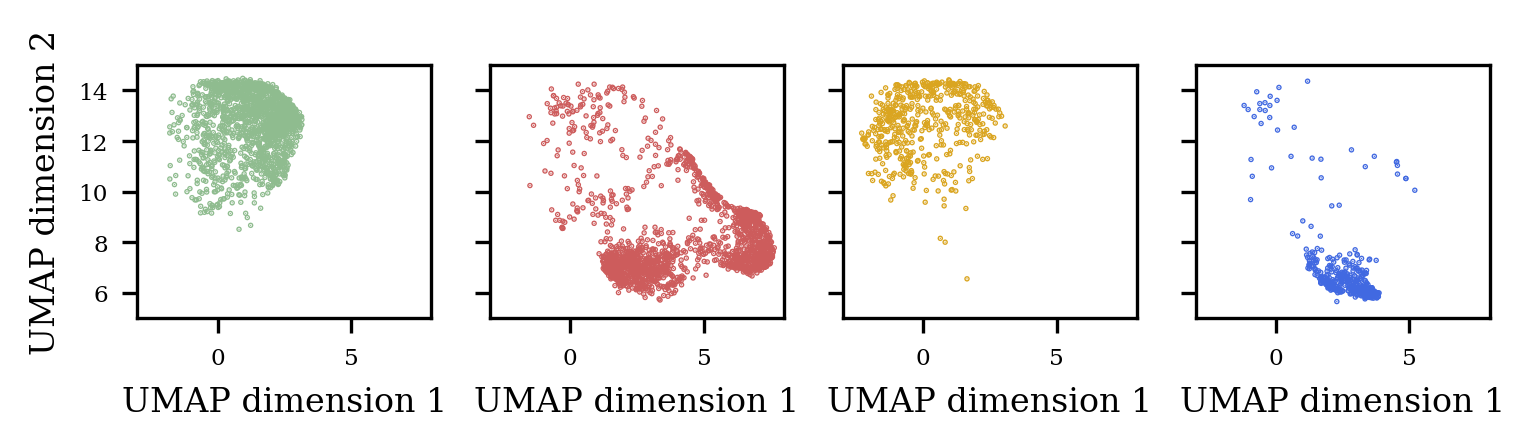

In [29]:
plot_umap_classes_indiv_2(embedded_fake, fake_labels, frac_width = 0.99, ratio = 0.25, xlabel=True, title=False, save_fig=True, save_name='fake_new')

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


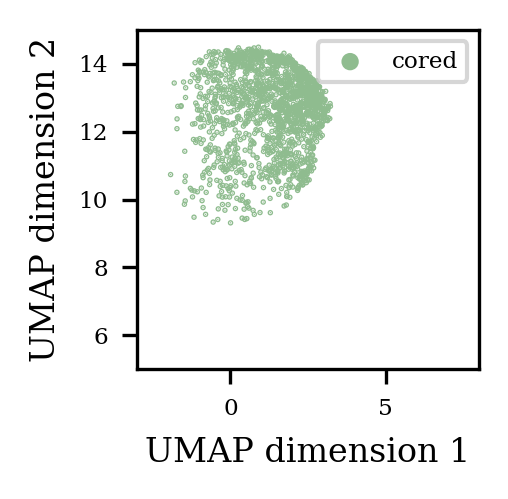

In [88]:
plot_umap_classes_indiv(embedded_fake, fake_labels, frac_width = 0.25, ratio = 1, xlabel=True, ylabel=True, legend=True, save_fig=True, save_name='fake', c=1)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


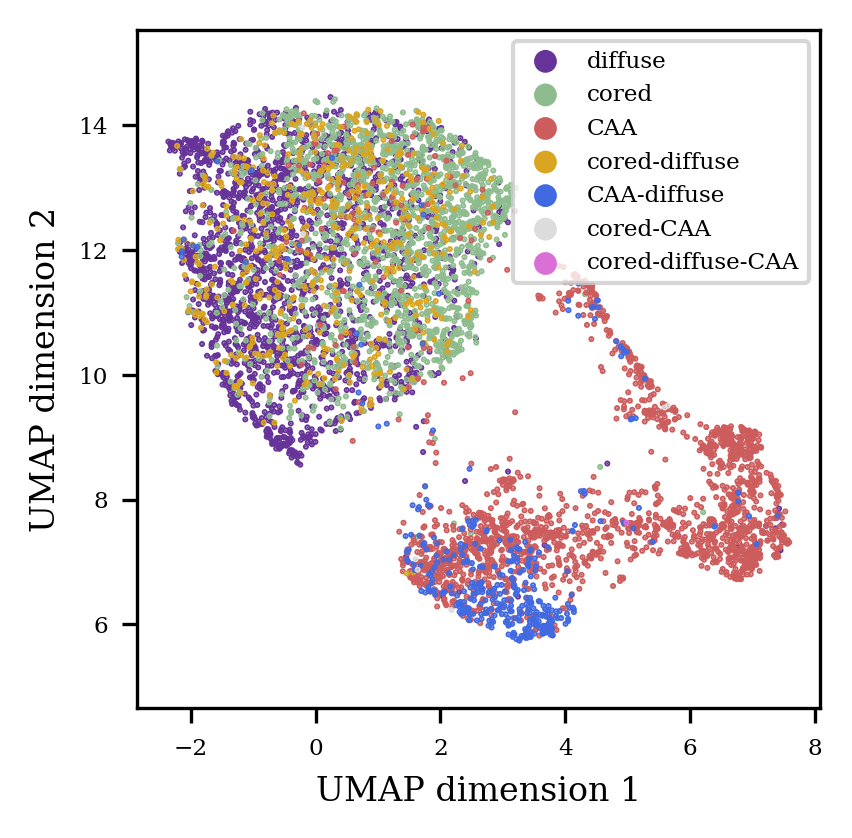

In [28]:
# UMAP of just the real examples
plot_umap(embedded_real, real_labels, real_vs_fake=False, frac_width = 0.5, ratio=1, save_fig=True, save_name='UMAP_real')

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


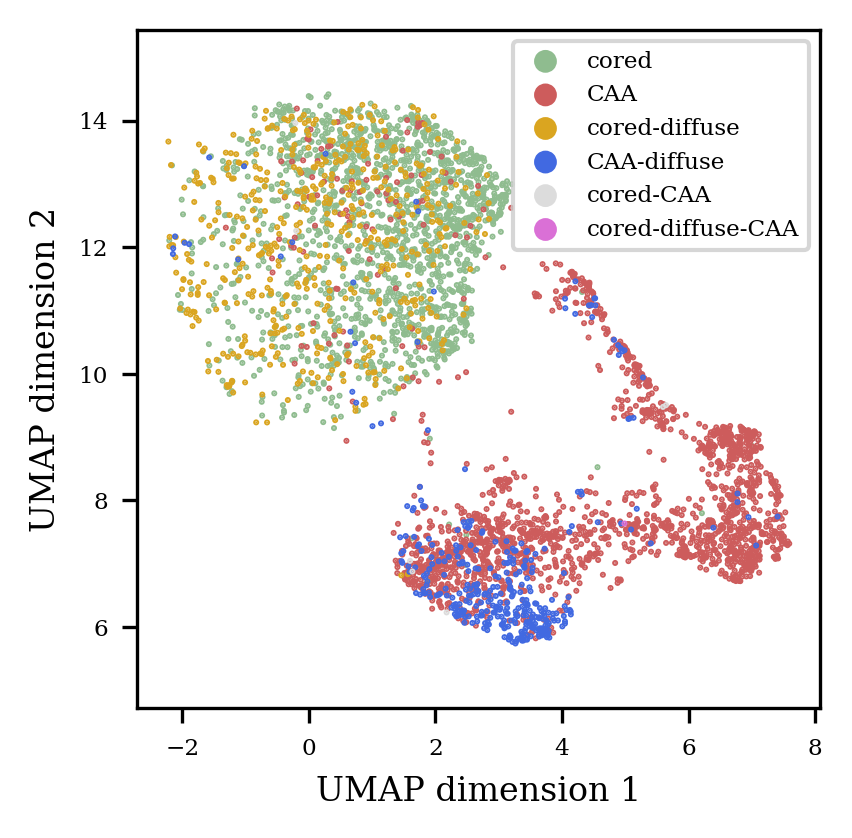

In [36]:
# UMAP of just the real minority examples
plot_umap(embedded_real[2000:], real_labels[2000:], real_vs_fake=False, frac_width = 0.5, ratio=1, save_fig=True, save_name='UMAP_real_minority')

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


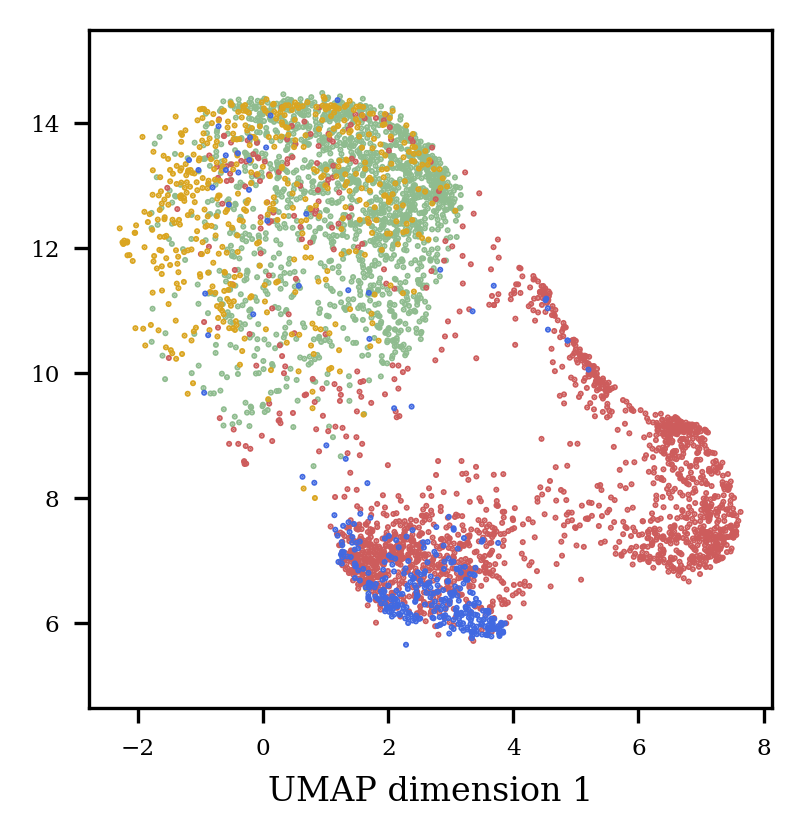

In [30]:
# UMAP of just the fake examples
plot_umap(embedded_fake, fake_labels, real_vs_fake=False, frac_width = 0.5, ratio=1, ylabel=False, legend=False, save_fig=True, save_name='UMAP_fake_final_new')

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


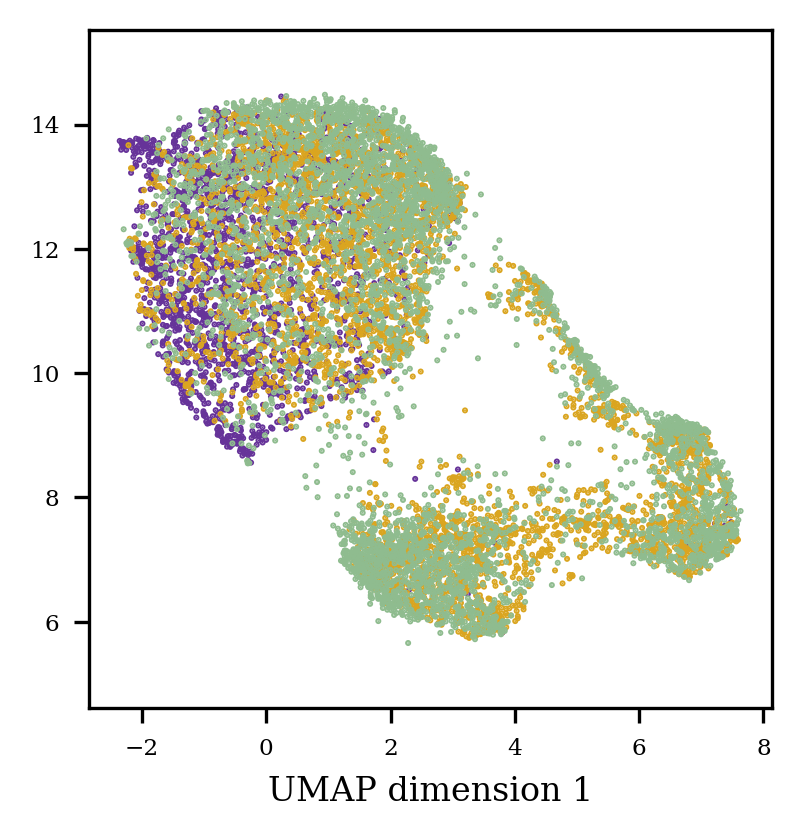

In [32]:
plot_umap(embedded, label_real_fake, frac_width = 0.5, ratio=1, ylabel=False, legend=False, save_fig=True, save_name='UMAP_rvg_final_new')

# plot_umap(embedded, label_real_fake, frac_width = 0.5, ratio=1, ylabel=False, legend=False, save_fig=True, save_name='UMAP_rvg_final')

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
No handles with labels found to put in legend.


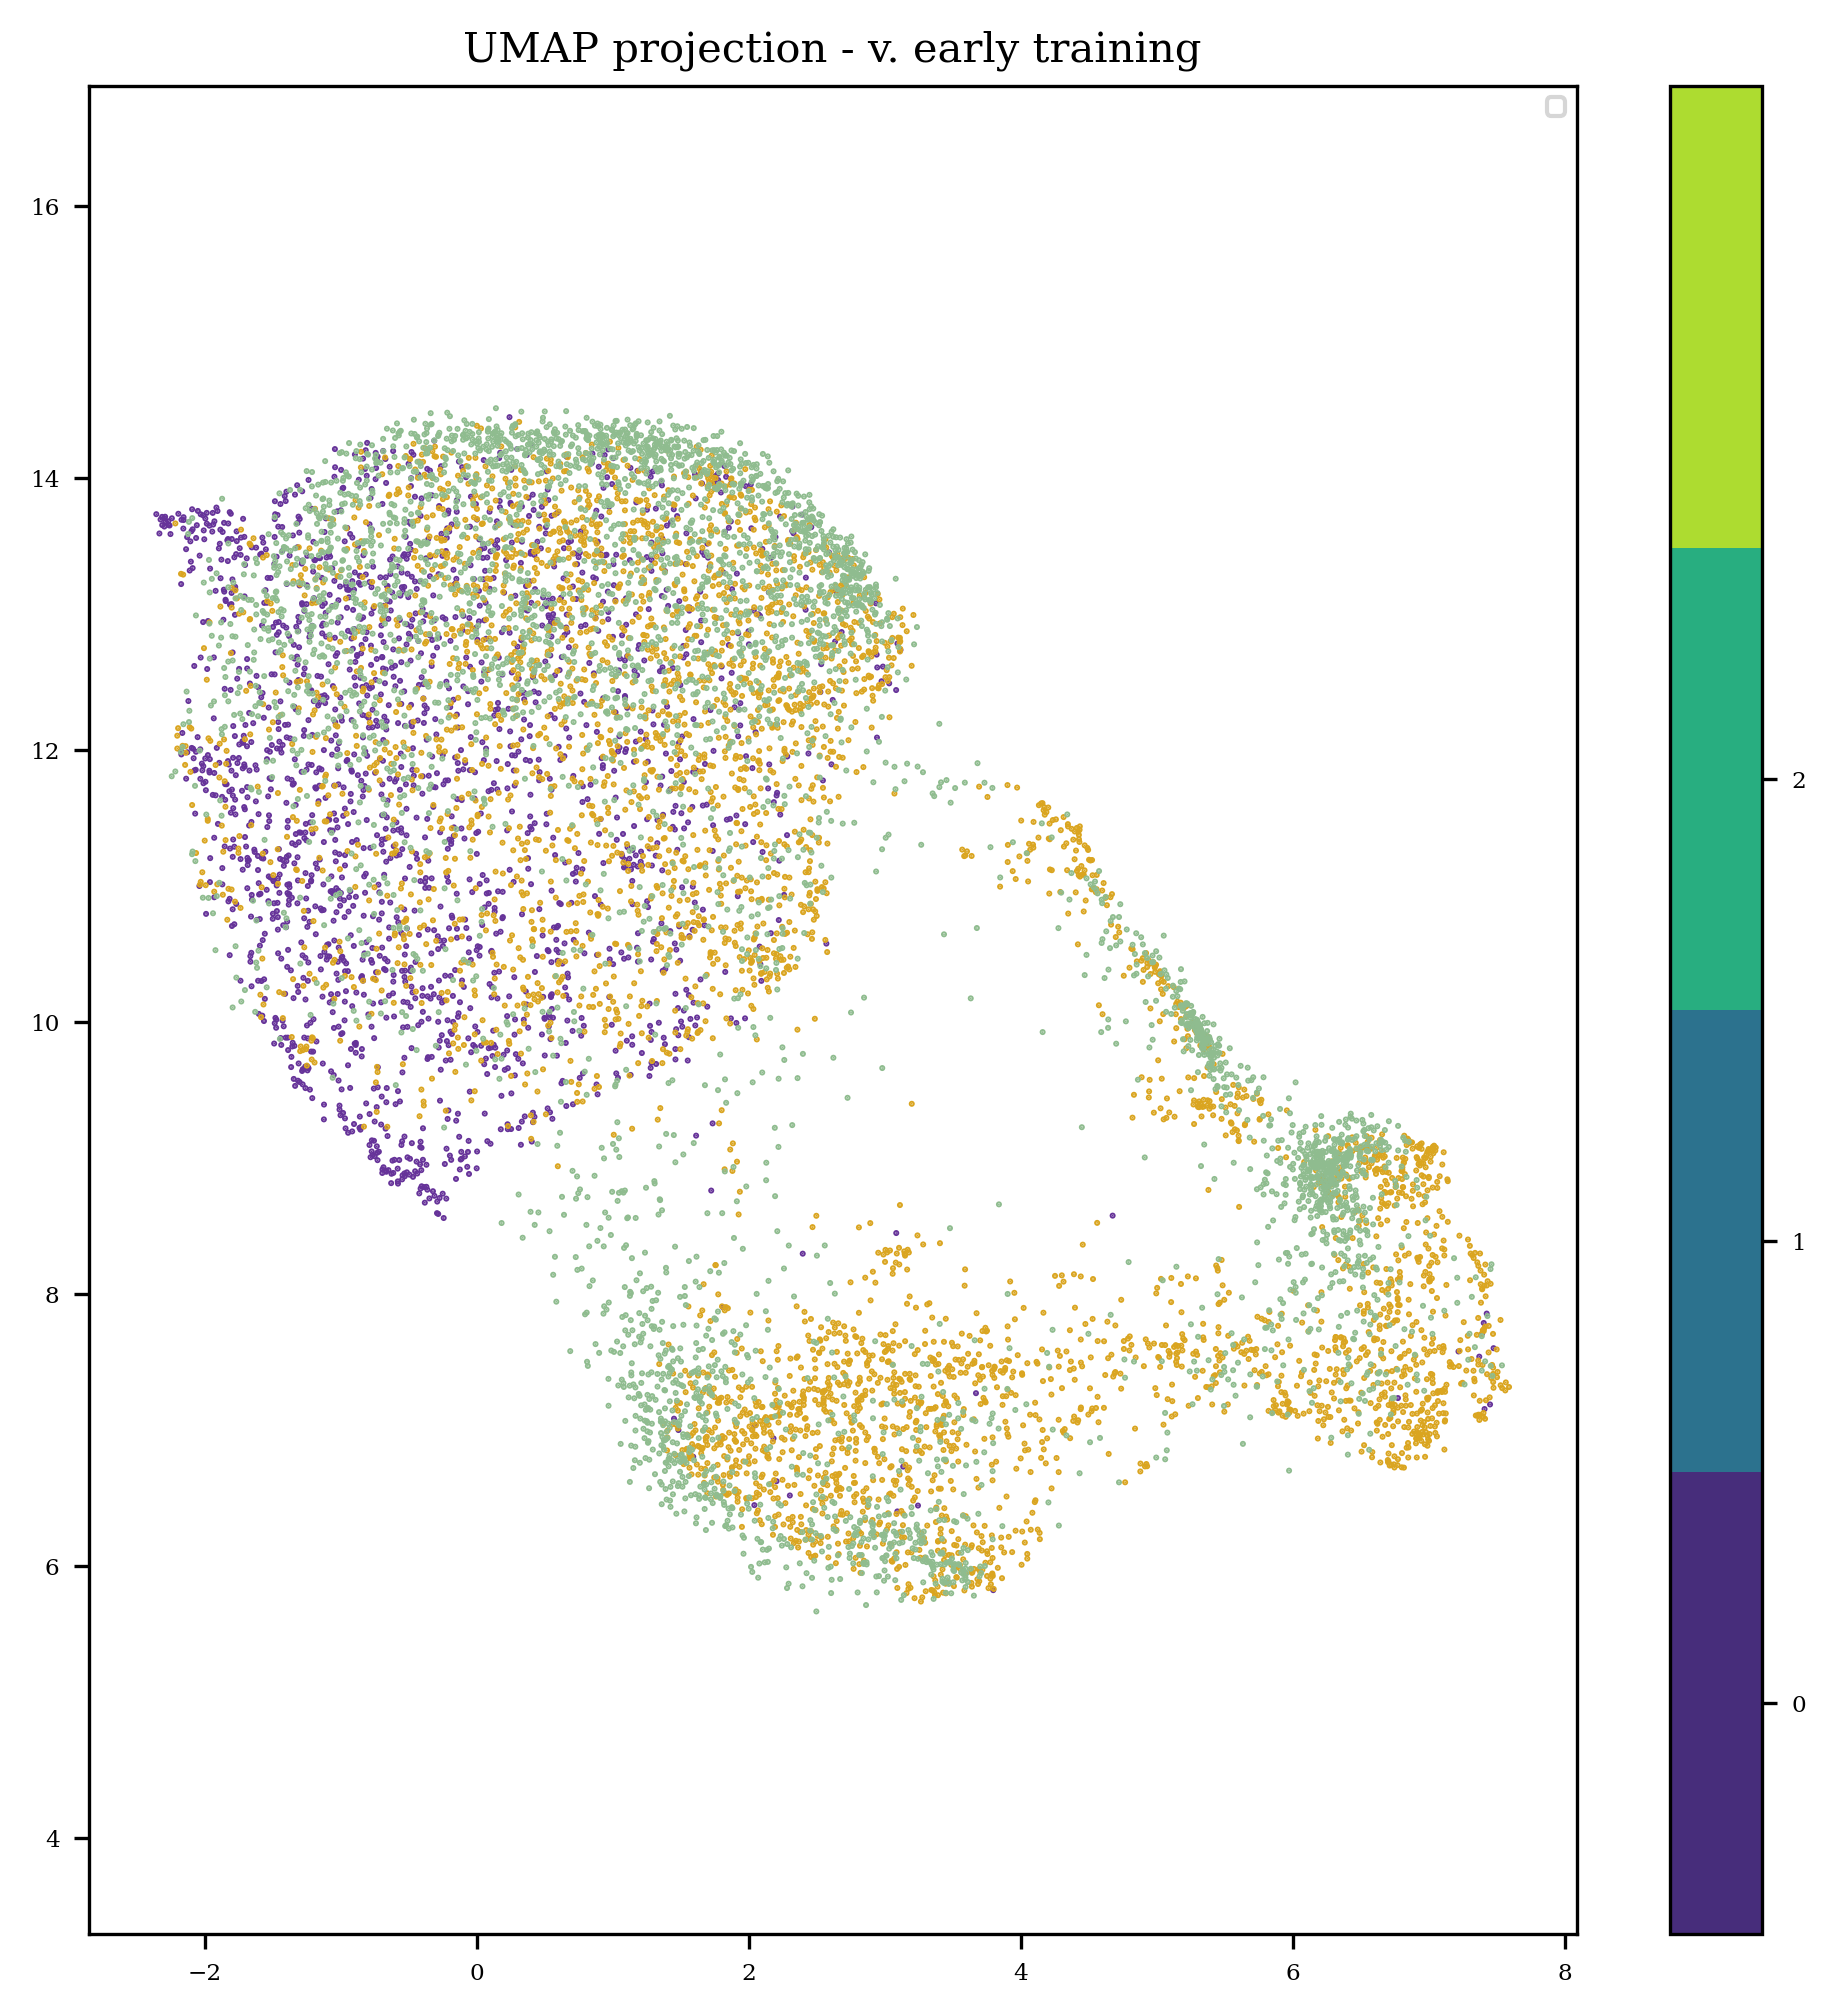

In [73]:
norm = plt.Normalize(vmin=0, vmax=7)
plt.figure(figsize=(8, 8))
plt.scatter(embedded[:, 0], embedded[:, 1], c=cmap_rvf(label_real_fake)[0], s=0.2)
# plt.scatter(embedded[:, 0], embedded[:, 1], c=label_real_fake, norm=norm, cmap='Paired', s=0.5)
plt.gca().set_aspect('equal', 'datalim')
# plt.gca().set_xlim(-4,3)
# plt.gca().set_ylim(7,13)
plt.legend()
plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(3))
plt.title('UMAP projection - v. early training', fontsize=10);